In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import json
import re
import pymysql
import pandas as pd
#sudo pip3 install ipywidgets ipydatetime
#jupyter nbextension enable --py widgetsnbextension
#jupyter nbextension enable --py ipydatetime
import ipywidgets as widgets
#import ipydatetime
import datetime
from IPython.display import display, clear_output, Markdown
pd.options.display.float_format = "{:.0f}".format
plt.rcParams['figure.figsize'] = [15,7]

In [2]:
with open('../../server/app/config.json') as json_data_file:
    data = json.load(json_data_file)
    url = data['SQLALCHEMY_DATABASE_URI']
    mux_port_threshold = data['MUX_PORT_THRESHOLD']
user, password, host, database = re.match('mysql://(.*?):(.*?)@(.*?)/(.*)', url).groups()
conn = pymysql.connect(host=host,port=3306,user=user,passwd=password,db=database)

In [3]:
query_39732c="""
    SELECT  TIMESTAMP,
            DATA->'$.DATA.NODE.FREE_HEAP' AS FREE_HEAP,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX0' AS MUX0,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX1' AS MUX1,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX2' AS MUX2,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX3' AS MUX3,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX4' AS MUX4,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX5' AS MUX5,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX6' AS MUX6,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX7' AS MUX7
    FROM OASIS_DATA
    WHERE NODE_ID='oasis-39732c'
    ORDER BY TIMESTAMP asc
    """
df = pd.read_sql_query(query_39732c, conn).astype(int)
query_397c0e="""
    SELECT  TIMESTAMP,
            DATA->'$.DATA.DHT.TEMPERATURE' AS TEMPERATURE,
            DATA->'$.DATA.DHT.HUMIDITY' AS HUMIDITY
    FROM OASIS_DATA
    WHERE NODE_ID='oasis-397c0e'
    ORDER BY TIMESTAMP asc
    """
dft = pd.read_sql_query(query_397c0e, conn).astype(int)

In [4]:
print("Interval:", df['TIMESTAMP'][1] - df['TIMESTAMP'][0], "secs")
print("Duration:", int(df['TIMESTAMP'].tail(1) - df['TIMESTAMP'][0])/3600, "hrs")

Interval: 205 secs
Duration: 321.415 hrs


In [20]:
#mux_dropdown = widgets.Dropdown(options=muxes,value='MUX0', description='Sensor:')
muxes = ['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX7']
mux_checkbox = [widgets.Checkbox(description=mux, value=True,indent=False) for mux in muxes]
mux_checkboxes = widgets.HBox(mux_checkbox)
rolling = widgets.FloatSlider(
         value=60,
         min=1,
         max=200,
         step=1,
        description='Rolling:',
        )
timerange = widgets.IntRangeSlider(
        value=[df['TIMESTAMP'].min(), df['TIMESTAMP'].max()],
        min=df['TIMESTAMP'].min(),
        max=df['TIMESTAMP'].max(),
        step=5,
        description='Range:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
        layout=dict(width='95%')
        )

btn_filter_range = widgets.Button(description='Filter',button_style='danger')
btn_today = widgets.Button(description='Today',button_style='info')
btn_yesterday = widgets.Button(description='Yesterday',button_style='warning')
buttons = widgets.HBox((btn_filter_range, btn_today, btn_yesterday))

outt = widgets.Output()

def plot_time_range(start, end):
    with outt:
        clear_output()
        print("Start time:", datetime.datetime.fromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S'))
        print("  End time:", datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S'))
        selected_muxes = [checkbox.description for checkbox in mux_checkbox if checkbox.value]

        x = df[(df['TIMESTAMP'] > start) & 
            (df['TIMESTAMP'] < end)][selected_muxes].rolling(int(rolling.value)).mean().dropna()
        plt.rcParams['figure.figsize'] = [15,7]
        plt.plot(x)
        #plt.axhline(y=mux_port_threshold['WET'])
        #plt.axhline(y=mux_port_threshold['OFFLINE'])
        #plt.axhline(y=mux_port_threshold['NOSOIL'])
        plt.fill_between(x.index, mux_port_threshold['OFFLINE'], mux_port_threshold['WET'],
                         where=mux_port_threshold['WET'] > mux_port_threshold['OFFLINE'],
                facecolor='blue', alpha=0.2)
        plt.fill_between(x.index, mux_port_threshold['WET'], mux_port_threshold['NOSOIL'],
                 where=mux_port_threshold['NOSOIL'] > mux_port_threshold['WET'],
        facecolor='red', alpha=0.2)
        plt.legend(selected_muxes)
        plt.show()
def on_btn_filter_range_clicked(b):
    plot_time_range(timerange.value[0], timerange.value[1])
def on_btn_today(b):
    now = datetime.datetime.today()
    start_day = datetime.datetime(now.year,now.month,now.day,0,0,0)
    plot_time_range(start_day.timestamp(), now.timestamp())
def on_btn_yesterday(b):
    yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
    start_day = datetime.datetime(yesterday.year,yesterday.month,yesterday.day,0,0,0)
    end_day = datetime.datetime(yesterday.year,yesterday.month,yesterday.day,23,59,59)
    plot_time_range(start_day.timestamp(), end_day.timestamp())
    
btn_filter_range.on_click(on_btn_filter_range_clicked)
btn_today.on_click(on_btn_today)
btn_yesterday.on_click(on_btn_yesterday)

widgets.VBox([mux_checkboxes, rolling, timerange, buttons, outt])

In [5]:
df[['FREE_HEAP','MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].describe()

,FREE_HEAP,MUX0,MUX1,MUX2,MUX3,MUX4,MUX5,MUX6,MUX7
count,19200,19200,19200,19200,19200,19200,19200,19200,19200
mean,32731,263,246,273,249,258,277,270,266
std,540,10,7,13,7,6,8,8,9
min,31480,236,225,242,224,237,257,248,243
25%,32344,256,241,262,244,254,271,264,259
50%,32344,262,246,271,248,258,278,270,266
75%,33320,269,252,281,255,262,283,277,272
max,33448,301,265,312,272,279,303,294,295


In [6]:
dft[['TEMPERATURE','HUMIDITY']].describe()

,TEMPERATURE,HUMIDITY
count,38395,38395
mean,27,25
std,2,9
min,20,12
25%,26,17
50%,27,24
75%,28,32
max,43,64


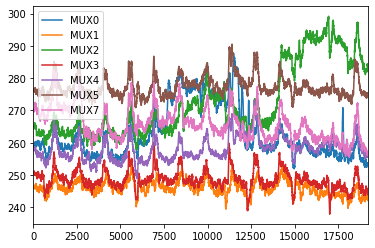

In [7]:
df[['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX7']].rolling(60).mean().plot()

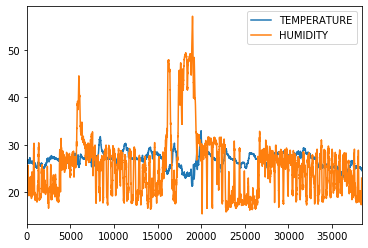

In [8]:
dft[['TEMPERATURE','HUMIDITY']].rolling(60).mean().plot()